In [2]:
# Блок 1: Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Настройка графиков
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['figure.dpi'] = 100

In [3]:
# Блок 2: Загрузка данных
print("Загрузка данных...")

# MATLAB данные (100 кГц)
def load_matlab(filename):
    df = pd.read_csv(filename)
    df.columns = ['continuous', 'discrete', 'setpoint']
    df['time'] = np.arange(len(df)) / 100000.0  # 100 кГц
    return df

linear_matlab = load_matlab('linear_sim.csv')
filter_matlab = load_matlab('filter_sim.csv')
step_matlab = load_matlab('step_sim.csv')

# MCU данные (1 кГц)
def load_mcu(filename):
    df = pd.read_csv(filename)
    # Берем только 2 и 3 столбцы
    df = df.iloc[:, [1, 2]]
    df.columns = ['process', 'setpoint']
    df['time'] = np.arange(len(df)) / 1000.0  # 1 кГц
    return df

MCU_linear = load_mcu('MCU_linear_response.csv')
MCU_filter = load_mcu('MCU_filter_response.csv')
MCU_step = load_mcu('MCU_step_response.csv')

Загрузка данных...


In [4]:
# Блок 3: Синхронизация данных по setpoint
def sync_by_setpoint(matlab_data, mcu_data):
    """Синхронизируем по началу изменения setpoint"""
    
    # Находим, где setpoint начинает меняться (первое ненулевое значение для MATLAB)
    matlab_setpoint = matlab_data['setpoint'].values
    mcu_setpoint = mcu_data['setpoint'].values
    
    # MATLAB: ищем где setpoint становится больше 0.1
    matlab_start_idx = np.where(np.abs(matlab_setpoint) > 0.1)[0]
    matlab_start_idx = matlab_start_idx[0] if len(matlab_start_idx) > 0 else 0
    
    # MCU: ищем где setpoint становится больше 0.1
    mcu_start_idx = np.where(np.abs(mcu_setpoint) > 0.1)[0]
    mcu_start_idx = mcu_start_idx[0] if len(mcu_start_idx) > 0 else 0
    
    # Обрезаем данные до 2.5 секунд с момента начала
    max_time = 2.5
    
    # MATLAB: берем данные от matlab_start_idx до достижения 2.5 сек
    matlab_sync = matlab_data.iloc[matlab_start_idx:].copy()
    # Масштабируем время с 0
    matlab_sync['time_sync'] = matlab_sync['time'] - matlab_sync['time'].iloc[0]
    # Обрезаем до 2.5 сек
    matlab_sync = matlab_sync[matlab_sync['time_sync'] <= max_time]
    
    # MCU: берем данные от mcu_start_idx до достижения 2.5 сек
    mcu_sync = mcu_data.iloc[mcu_start_idx:].copy()
    # Масштабируем время с 0
    mcu_sync['time_sync'] = mcu_sync['time'] - mcu_sync['time'].iloc[0]
    # Обрезаем до 2.5 сек
    mcu_sync = mcu_sync[mcu_sync['time_sync'] <= max_time]
    
    return matlab_sync, mcu_sync

# Синхронизируем все наборы данных
print("\nСинхронизация данных...")
linear_matlab_sync, linear_mcu_sync = sync_by_setpoint(linear_matlab, MCU_linear)
filter_matlab_sync, filter_mcu_sync = sync_by_setpoint(filter_matlab, MCU_filter)
step_matlab_sync, step_mcu_sync = sync_by_setpoint(step_matlab, MCU_step)


Синхронизация данных...



Построение графиков...

LINEAR СИСТЕМА


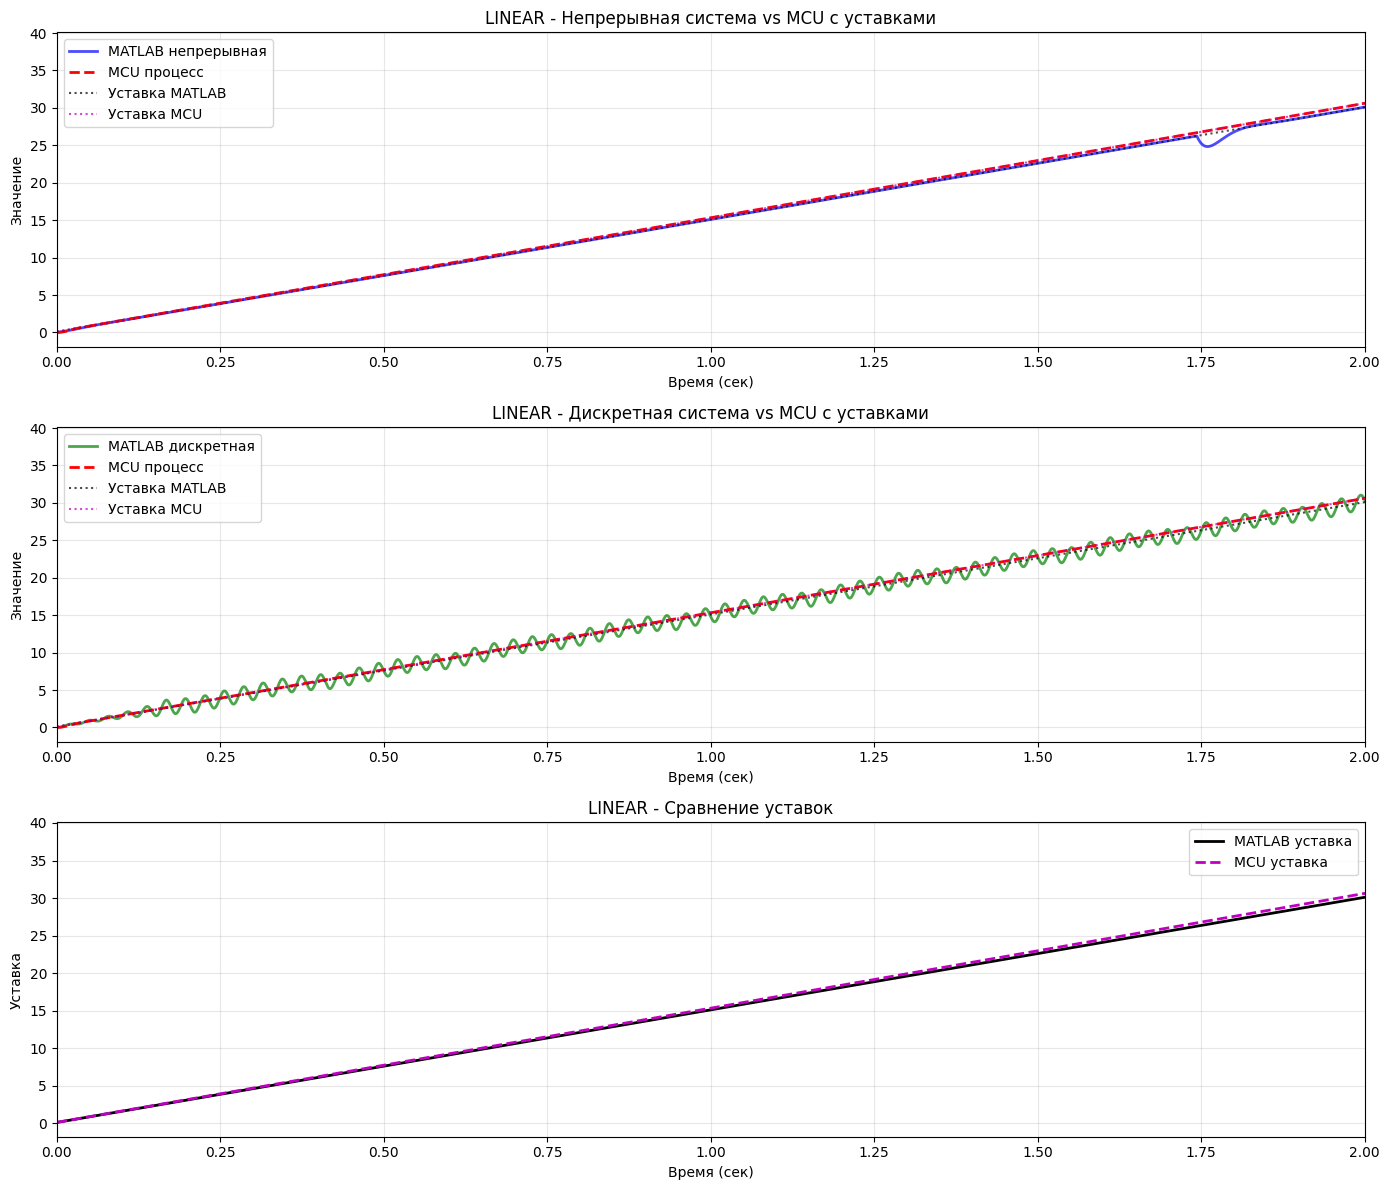


FILTER СИСТЕМА


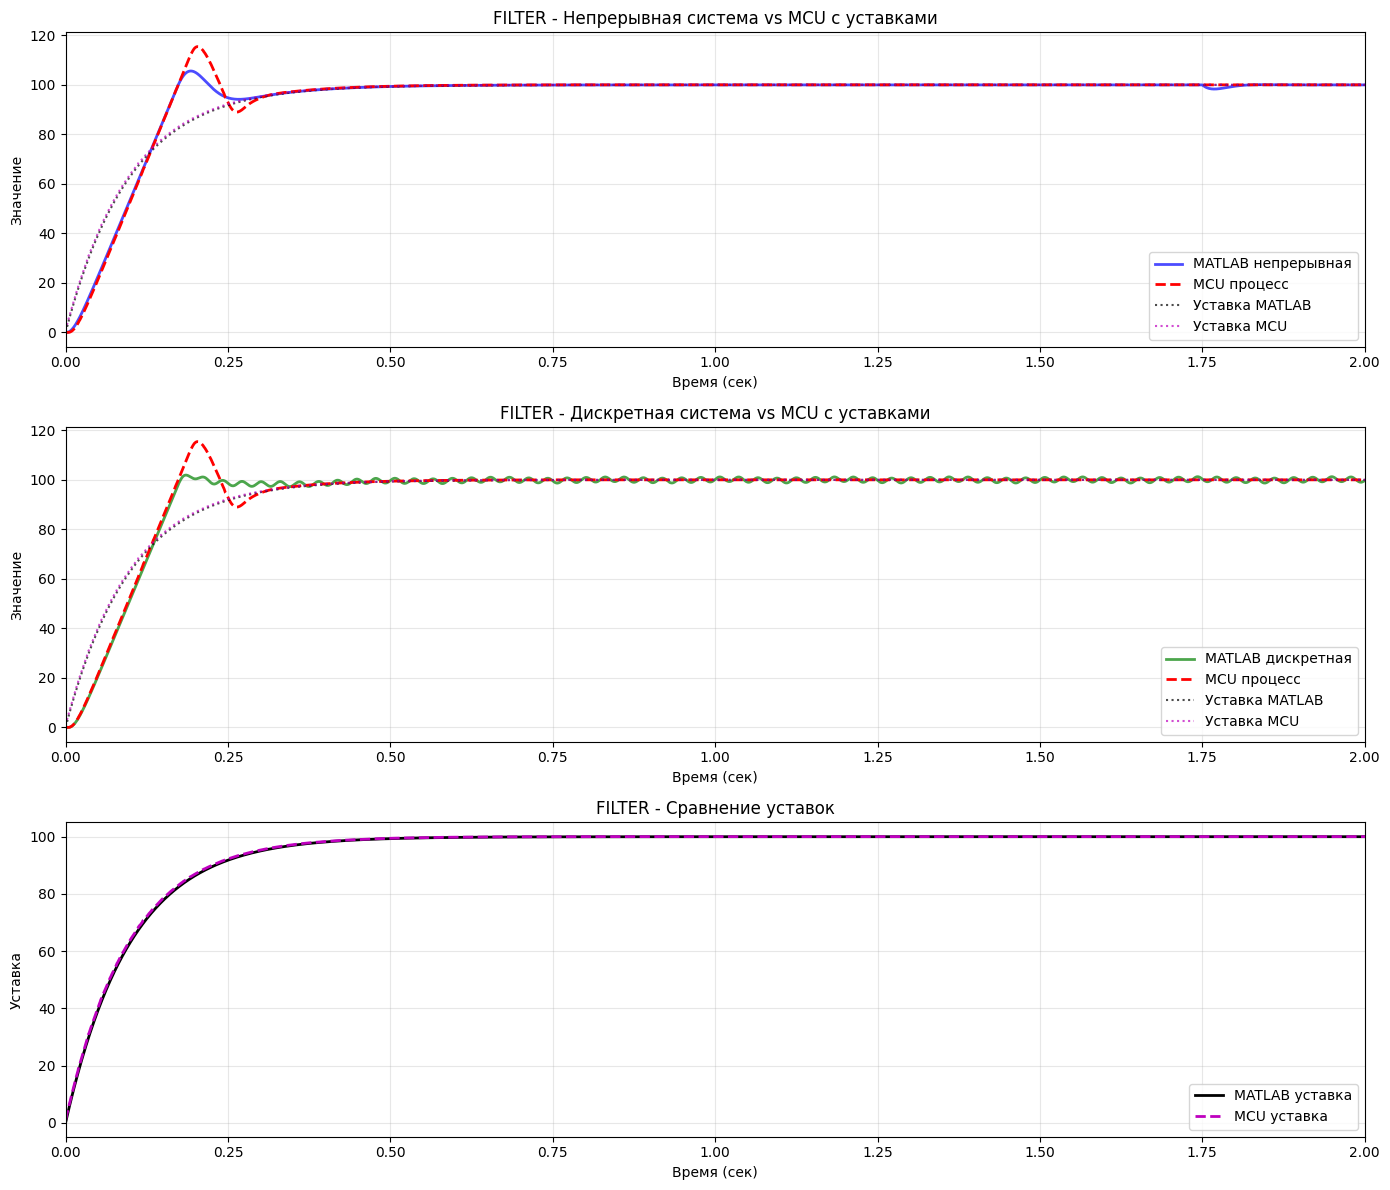


STEP СИСТЕМА


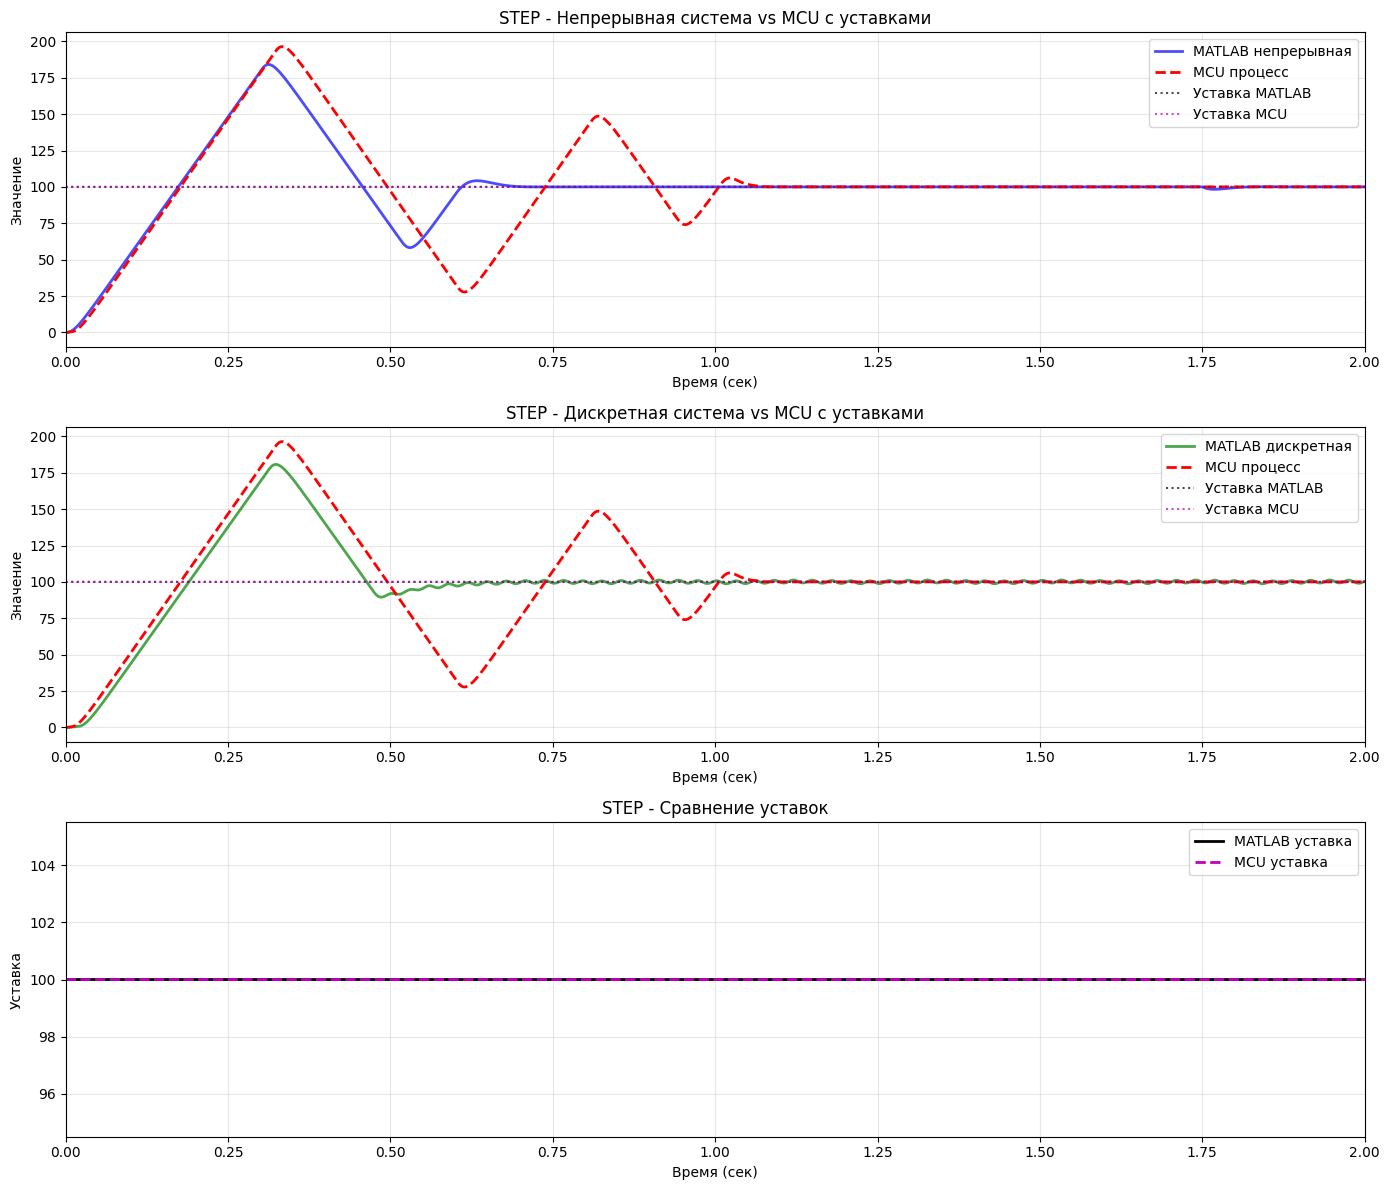

In [5]:
# Блок 4: Визуализация (3x1 графиков, 3 раза)
print("\nПостроение графиков...")

# Функция для построения одного набора из 3 графиков
def plot_system_comparison(matlab_sync, mcu_sync, title):
    """Построение 3 графиков для одной системы"""
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Прореживаем MATLAB данные для лучшего отображения
    if len(mcu_sync) > 0:
        matlab_downsample = max(1, len(matlab_sync) // len(mcu_sync))
    else:
        matlab_downsample = 100
    matlab_plot = matlab_sync.iloc[::matlab_downsample]
    
    # График 1: Непрерывная система MATLAB vs MCU с уставкой
    ax1 = axes[0]
    # Основные сигналы
    ax1.plot(matlab_plot['time_sync'], matlab_plot['continuous'], 
             'b-', label='MATLAB непрерывная', linewidth=2, alpha=0.7)
    ax1.plot(mcu_sync['time_sync'], mcu_sync['process'], 
             'r--', label='MCU процесс', linewidth=2)
    # Уставки поверх
    ax1.plot(matlab_plot['time_sync'], matlab_plot['setpoint'], 
             'k:', label='Уставка MATLAB', linewidth=1.5, alpha=0.7)
    ax1.plot(mcu_sync['time_sync'], mcu_sync['setpoint'], 
             'm:', label='Уставка MCU', linewidth=1.5, alpha=0.7)
    
    ax1.set_title(f'{title} - Непрерывная система vs MCU с уставками')
    ax1.set_xlabel('Время (сек)')
    ax1.set_ylabel('Значение')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 2])
    
    # График 2: Дискретная система MATLAB vs MCU с уставкой
    ax2 = axes[1]
    # Основные сигналы
    ax2.plot(matlab_plot['time_sync'], matlab_plot['discrete'], 
             'g-', label='MATLAB дискретная', linewidth=2, alpha=0.7)
    ax2.plot(mcu_sync['time_sync'], mcu_sync['process'], 
             'r--', label='MCU процесс', linewidth=2)
    # Уставки поверх
    ax2.plot(matlab_plot['time_sync'], matlab_plot['setpoint'], 
             'k:', label='Уставка MATLAB', linewidth=1.5, alpha=0.7)
    ax2.plot(mcu_sync['time_sync'], mcu_sync['setpoint'], 
             'm:', label='Уставка MCU', linewidth=1.5, alpha=0.7)
    
    ax2.set_title(f'{title} - Дискретная система vs MCU с уставками')
    ax2.set_xlabel('Время (сек)')
    ax2.set_ylabel('Значение')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 2])
    
    # График 3: Только уставки
    ax3 = axes[2]
    ax3.plot(matlab_plot['time_sync'], matlab_plot['setpoint'], 
             'k-', label='MATLAB уставка', linewidth=2)
    ax3.plot(mcu_sync['time_sync'], mcu_sync['setpoint'], 
             'm--', label='MCU уставка', linewidth=2)
    ax3.set_title(f'{title} - Сравнение уставок')
    ax3.set_xlabel('Время (сек)')
    ax3.set_ylabel('Уставка')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([0, 2])
    
    plt.tight_layout()
    plt.show()

# Построение графиков для каждой системы
print("\n" + "="*60)
print("LINEAR СИСТЕМА")
print("="*60)
plot_system_comparison(linear_matlab_sync, linear_mcu_sync, 'LINEAR')

print("\n" + "="*60)
print("FILTER СИСТЕМА")
print("="*60)
plot_system_comparison(filter_matlab_sync, filter_mcu_sync, 'FILTER')

print("\n" + "="*60)
print("STEP СИСТЕМА")
print("="*60)
plot_system_comparison(step_matlab_sync, step_mcu_sync, 'STEP')


Построение графиков...

LINEAR СИСТЕМА - СРАВНЕНИЕ ПЕРЕХОДНЫХ ПРОЦЕССОВ
График сохранен как: LINEAR_comparison_A4.png


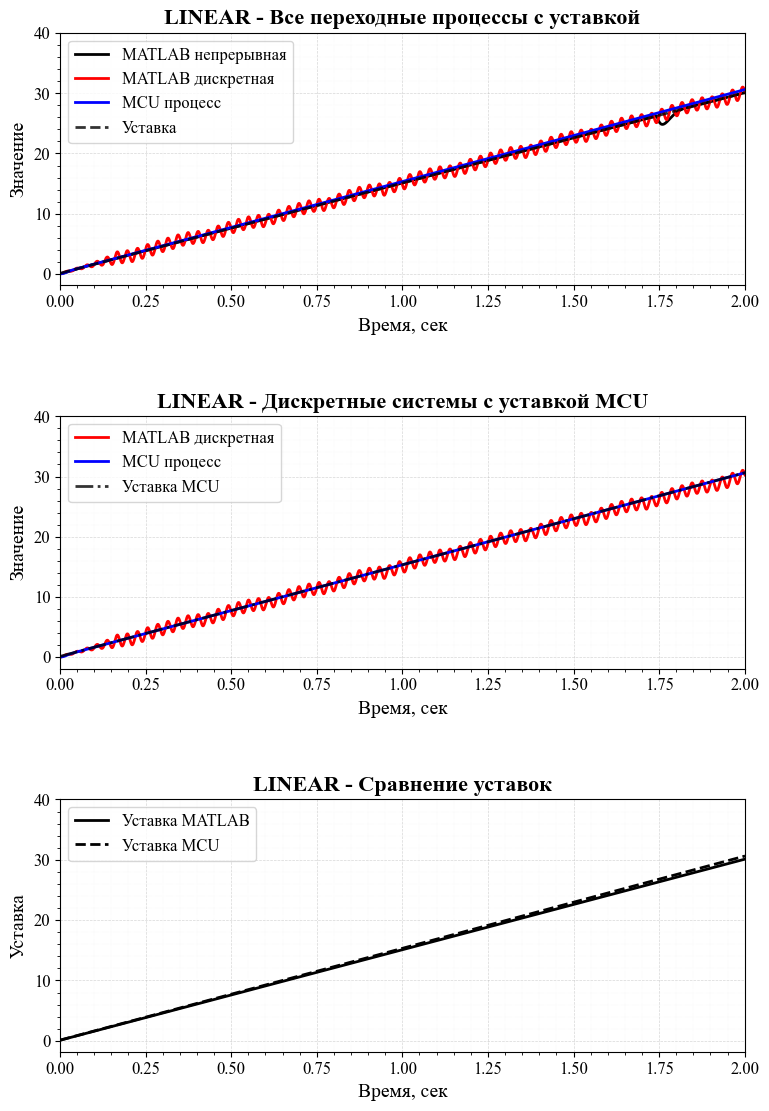


FILTER СИСТЕМА - СРАВНЕНИЕ ПЕРЕХОДНЫХ ПРОЦЕССОВ
График сохранен как: FILTER_comparison_A4.png


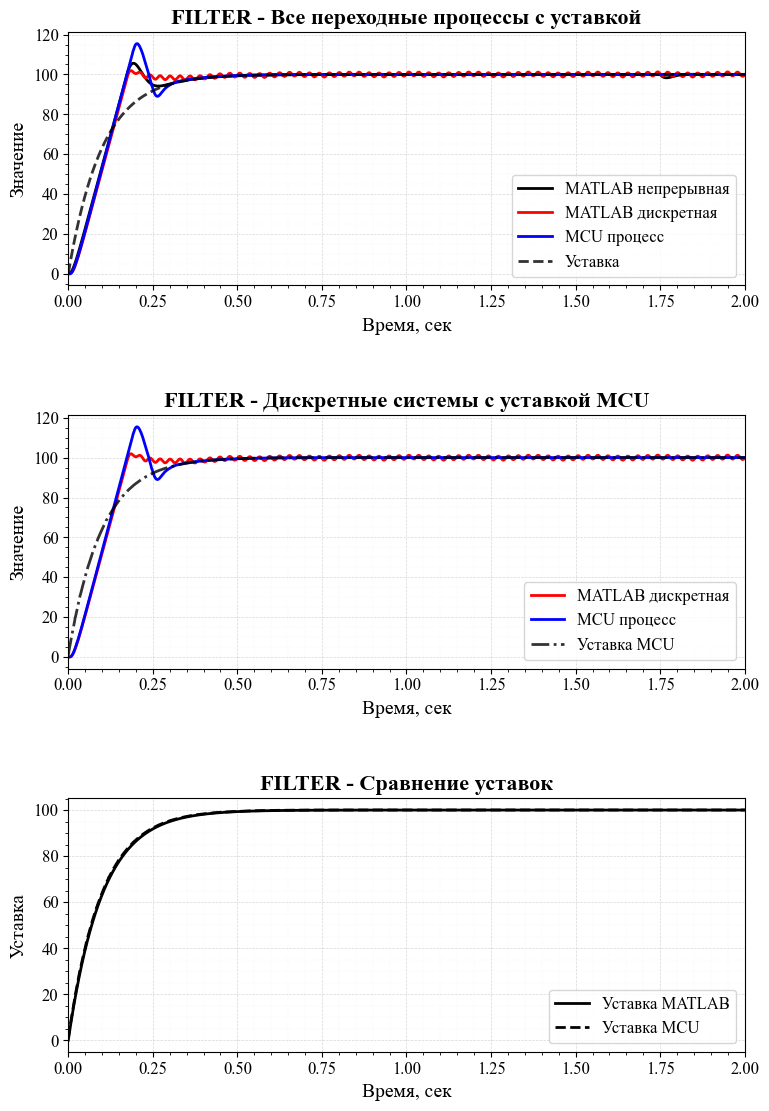


STEP СИСТЕМА - СРАВНЕНИЕ ПЕРЕХОДНЫХ ПРОЦЕССОВ
График сохранен как: STEP_comparison_A4.png


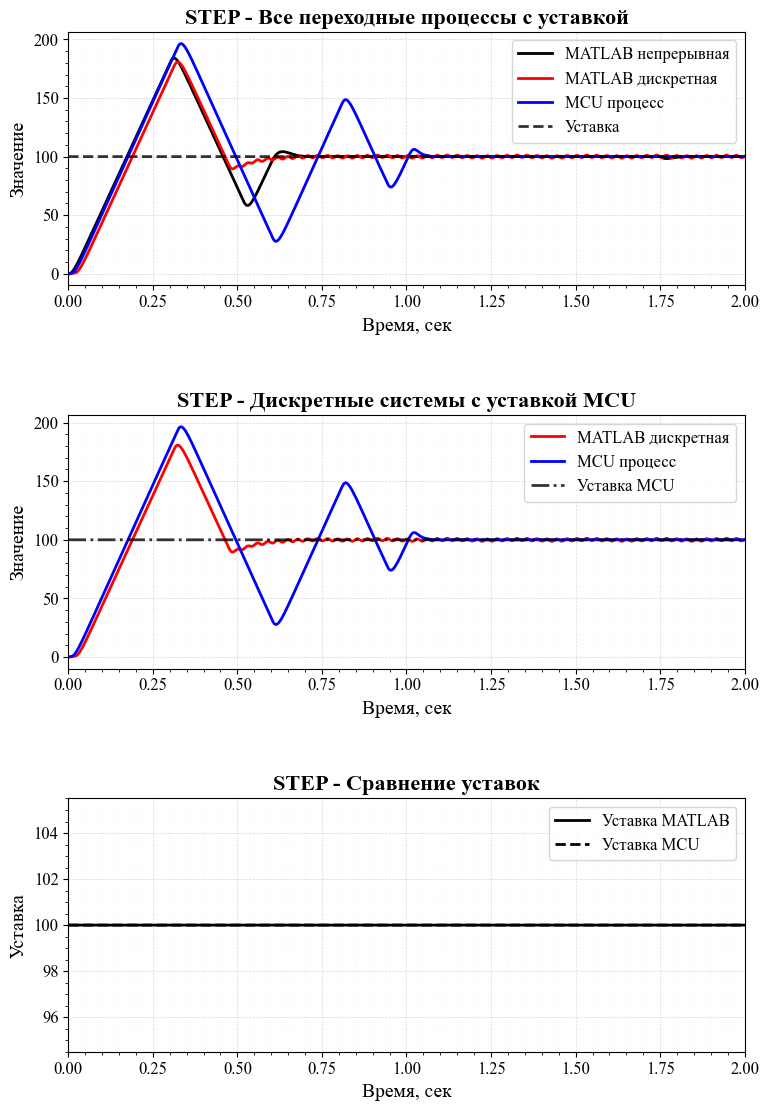


СТАТИСТИКА ДАННЫХ (0-2 секунды)

LINEAR:
  MATLAB: 224334 точек, время: 0.000 - 2.243 сек
  MCU:    2501 точек, время: 0.000 - 2.500 сек
  RMSE между MATLAB дискретной и MCU: 2.707345
  Максимальная ошибка: 13.349102
  Время установления (до 5%): 2.327 сек

FILTER:
  MATLAB: 224990 точек, время: 0.000 - 2.250 сек
  MCU:    2501 точек, время: 0.000 - 2.500 сек
  RMSE между MATLAB дискретной и MCU: 9.449581
  Максимальная ошибка: 50.431648
  Время установления (до 5%): 0.166 сек

STEP:
  MATLAB: 225001 точек, время: 0.000 - 2.250 сек
  MCU:    2478 точек, время: 0.000 - 2.477 сек
  RMSE между MATLAB дискретной и MCU: 19.049533
  Максимальная ошибка: 71.357996
  Время установления (до 5%): 0.169 сек


In [7]:
# Блок 4: Визуализация с оформлением для А4
print("\nПостроение графиков...")

# Устанавливаем шрифт Times New Roman и размеры для А4
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  # Увеличили размер шрифта
plt.rcParams['axes.titlesize'] = 16  # Размер заголовков
plt.rcParams['axes.labelsize'] = 14  # Размер подписей осей
plt.rcParams['legend.fontsize'] = 12  # Размер легенды
plt.rcParams['figure.titlesize'] = 18  # Размер заголовка фигуры

# Размеры для А4 листа в дюймах (А4: 210x297 мм = 8.27x11.69 дюймов)
A4_WIDTH = 8.27  # ширина А4 в дюймах
A4_HEIGHT = 11.69  # высота А4 в дюймах

# Функция для построения одного набора из 3 графиков
def plot_system_comparison(matlab_sync, mcu_sync, title):
    """Построение 3 графиков для одной системы с оформлением для А4"""
    
    # Создаем фигуру с размерами А4
    fig = plt.figure(figsize=(A4_WIDTH, A4_HEIGHT))
    
    # Прореживаем MATLAB данные для лучшего отображения
    if len(mcu_sync) > 0 and len(matlab_sync) > len(mcu_sync):
        matlab_downsample = max(1, len(matlab_sync) // len(mcu_sync))
    else:
        matlab_downsample = 100
    matlab_plot = matlab_sync.iloc[::matlab_downsample]
    
    # График 1: 3 переходных процесса и уставка MATLAB
    ax1 = plt.subplot(3, 1, 1)
    
    # 1. Непрерывная система MATLAB (чёрный, сплошная)
    ax1.plot(matlab_plot['time_sync'], matlab_plot['continuous'], 
             'k-', label='MATLAB непрерывная', linewidth=2)
    
    # 2. Дискретная система MATLAB (красный, сплошная)
    ax1.plot(matlab_plot['time_sync'], matlab_plot['discrete'], 
             'r-', label='MATLAB дискретная', linewidth=2)
    
    # 3. Система MCU (синий, сплошная)
    ax1.plot(mcu_sync['time_sync'], mcu_sync['process'], 
             'b-', label='MCU процесс', linewidth=2)
    
    # 4. Уставка MATLAB (чёрный, пунктир)
    ax1.plot(matlab_plot['time_sync'], matlab_plot['setpoint'], 
             'k--', label='Уставка', linewidth=2, alpha=0.8)
    
    ax1.set_title(f'{title} - Все переходные процессы с уставкой', fontweight='bold')
    ax1.set_xlabel('Время, сек')
    ax1.set_ylabel('Значение')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xlim([0, 2])
    
    # Добавляем сетку с основной и дополнительной линиями
    ax1.minorticks_on()
    ax1.grid(which='major', alpha=0.5, linewidth=0.5)
    ax1.grid(which='minor', alpha=0.2, linestyle=':', linewidth=0.3)
    
    # Увеличиваем размер tick labels
    ax1.tick_params(axis='both', which='major', labelsize=12)
    
    # График 2: Дискретный MATLAB vs MCU с уставкой MCU
    ax2 = plt.subplot(3, 1, 2)
    
    # 1. Дискретная система MATLAB (красный, сплошная)
    ax2.plot(matlab_plot['time_sync'], matlab_plot['discrete'], 
             'r-', label='MATLAB дискретная', linewidth=2)
    
    # 2. Система MCU (синий, сплошная)
    ax2.plot(mcu_sync['time_sync'], mcu_sync['process'], 
             'b-', label='MCU процесс', linewidth=2)
    
    # 3. Уставка MCU (чёрный, штрих-пунктир)
    ax2.plot(mcu_sync['time_sync'], mcu_sync['setpoint'], 
             'k-.', label='Уставка MCU', linewidth=2, alpha=0.8)
    
    ax2.set_title(f'{title} - Дискретные системы с уставкой MCU', fontweight='bold')
    ax2.set_xlabel('Время, сек')
    ax2.set_ylabel('Значение')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_xlim([0, 2])
    
    # Добавляем сетку с основной и дополнительной линиями
    ax2.minorticks_on()
    ax2.grid(which='major', alpha=0.5, linewidth=0.5)
    ax2.grid(which='minor', alpha=0.2, linestyle=':', linewidth=0.3)
    
    # Увеличиваем размер tick labels
    ax2.tick_params(axis='both', which='major', labelsize=12)
    
    # График 3: Наложение уставок
    ax3 = plt.subplot(3, 1, 3)
    
    # 1. Уставка MATLAB (чёрный, сплошная)
    ax3.plot(matlab_plot['time_sync'], matlab_plot['setpoint'], 
             'k-', label='Уставка MATLAB', linewidth=2)
    
    # 2. Уставка MCU (чёрный, пунктир)
    ax3.plot(mcu_sync['time_sync'], mcu_sync['setpoint'], 
             'k--', label='Уставка MCU', linewidth=2)
    
    ax3.set_title(f'{title} - Сравнение уставок', fontweight='bold')
    ax3.set_xlabel('Время, сек')
    ax3.set_ylabel('Уставка')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.set_xlim([0, 2])
    
    # Добавляем сетку с основной и дополнительной линиями
    ax3.minorticks_on()
    ax3.grid(which='major', alpha=0.5, linewidth=0.5)
    ax3.grid(which='minor', alpha=0.2, linestyle=':', linewidth=0.3)
    
    # Увеличиваем размер tick labels
    ax3.tick_params(axis='both', which='major', labelsize=12)
    
    # Настраиваем расположение подграфиков
    plt.tight_layout(pad=2.0, h_pad=3.0, w_pad=2.0)  # Увеличили отступы между графиками
    
    # Сохраняем график в файл (опционально)
    filename = f"{title}_comparison_A4.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')
    print(f"График сохранен как: {filename}")
    
    plt.show()

# Построение графиков для каждой системы
print("\n" + "="*80)
print("LINEAR СИСТЕМА - СРАВНЕНИЕ ПЕРЕХОДНЫХ ПРОЦЕССОВ")
print("="*80)
plot_system_comparison(linear_matlab_sync, linear_mcu_sync, 'LINEAR')

print("\n" + "="*80)
print("FILTER СИСТЕМА - СРАВНЕНИЕ ПЕРЕХОДНЫХ ПРОЦЕССОВ")
print("="*80)
plot_system_comparison(filter_matlab_sync, filter_mcu_sync, 'FILTER')

print("\n" + "="*80)
print("STEP СИСТЕМА - СРАВНЕНИЕ ПЕРЕХОДНЫХ ПРОЦЕССОВ")
print("="*80)
plot_system_comparison(step_matlab_sync, step_mcu_sync, 'STEP')

# Блок 5: Вывод статистики
print("\n" + "="*80)
print("СТАТИСТИКА ДАННЫХ (0-2 секунды)")
print("="*80)

datasets = [
    ('LINEAR', linear_matlab_sync, linear_mcu_sync),
    ('FILTER', filter_matlab_sync, filter_mcu_sync),
    ('STEP', step_matlab_sync, step_mcu_sync)
]

for name, matlab, mcu in datasets:
    print(f"\n{name}:")
    print(f"  MATLAB: {len(matlab)} точек, время: {matlab['time_sync'].iloc[0]:.3f} - {matlab['time_sync'].iloc[-1]:.3f} сек")
    print(f"  MCU:    {len(mcu)} точек, время: {mcu['time_sync'].iloc[0]:.3f} - {mcu['time_sync'].iloc[-1]:.3f} сек")
    
    if len(mcu) > 0:
        # Вычисляем ошибку между дискретной MATLAB и MCU
        from scipy.interpolate import interp1d
        
        # Создаем интерполятор для MATLAB данных
        interp_func = interp1d(matlab['time_sync'], matlab['discrete'], 
                               bounds_error=False, fill_value='extrapolate')
        
        # Интерполируем на временные точки MCU
        matlab_interp = interp_func(mcu['time_sync'])
        
        # Вычисляем ошибку
        error = matlab_interp - mcu['process']
        rmse = np.sqrt(np.mean(error**2))
        
        print(f"  RMSE между MATLAB дискретной и MCU: {rmse:.6f}")
        print(f"  Максимальная ошибка: {np.max(np.abs(error)):.6f}")
        
        # Вычисляем время установления (до 5% от уставки)
        steady_state_value = mcu['setpoint'].iloc[-100:].mean() if len(mcu) > 100 else mcu['setpoint'].iloc[-1]
        settling_threshold = 0.05 * abs(steady_state_value)
        
        # Ищем, когда ошибка входит в диапазон ±5%
        error_to_settle = np.abs(mcu['process'].values - steady_state_value)
        settling_idx = np.where(error_to_settle < settling_threshold)[0]
        
        if len(settling_idx) > 0:
            settling_time = mcu['time_sync'].iloc[settling_idx[0]]
            print(f"  Время установления (до 5%): {settling_time:.3f} сек")